In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
try:
    import qvarnet
    from qvarnet.models.mlp import MLP
except ImportError:
    print("If variational approach, please install qvarnet.")

import copy

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

### Parameters

In [2]:
# PARAMETERS
HBAR = 1.0
MASS = 1.0
V0   = 1.0
K1   = 1.0
PBC  = True

N_POINTS = 1_000    # total number of points in (-L/2,+L/2)
N_PERIODS_FROM_CENTRE_TO_RIGHT = 0.5 # number of periods from the center to the right edge
L_BOX = 2*torch.pi/K1 * N_PERIODS_FROM_CENTRE_TO_RIGHT
GRID_SPACING = L_BOX / N_POINTS

### Exact diagonalization utils

#### Potential definition

In [3]:
def V(x,V0,K1):
    """Potential function."""
    return V0 * torch.sin(K1 * x).pow(2)

##### Potential drawing

''

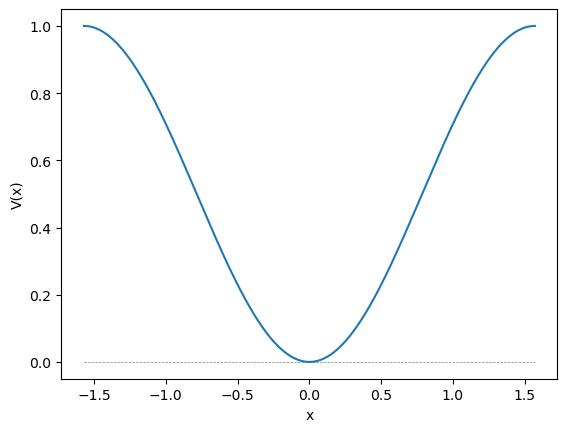

In [4]:
x_pot = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)

plt.hlines(0, -L_BOX/2, L_BOX/2, colors='gray', linestyles='dashed', linewidths=0.5)
plt.plot(x_pot.cpu().numpy(), V(x_pot,V0,K1).cpu().numpy(), label='Potential V(x)')
plt.xlabel('x')
plt.ylabel('V(x)')
;

#### Hamiltonian definition

In [5]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, potential_parameters, x):
    kin_coeff = -HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = -2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = 1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = V(x[i],**potential_parameters)
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

##### Local energy checking

Number of points in the grid: 1000
Box length: 3.141592653589793
torch.Size([1000, 1000])
Eigenvalue 0: 0.439550676111987
Eigenvalue 1: 2.4902389843640598
Eigenvalue 2: 2.5508386116035946
Eigenvalue 3: 8.504542792244544
Eigenvalue 4: 8.504591976281217


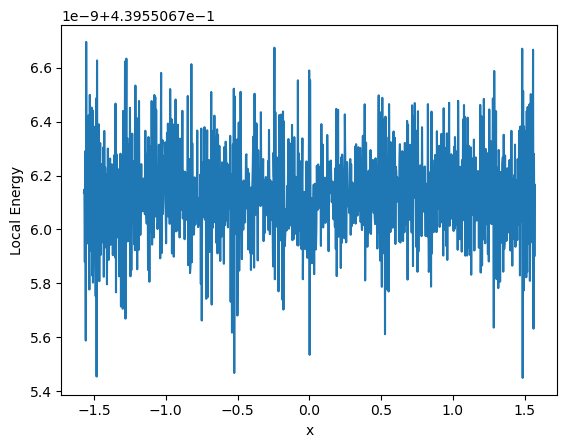

In [6]:
H = hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, {'V0': V0, 'K1': K1}, x_pot)
eigenvalues, eigenstates = torch.linalg.eigh(H)
print(f"Number of points in the grid: {N_POINTS}")
print(f"Box length: {L_BOX}")
print(eigenstates.shape)

for i in range(5):
    print(f'Eigenvalue {i}: {eigenvalues[i].item()}')

# check local energy
local_energy = H@eigenstates[:, 0] / eigenstates[:, 0]
plt.plot(x_pot.cpu().numpy(), local_energy.cpu().numpy(), label='Local Energy')
plt.xlabel('x')
plt.ylabel('Local Energy');

In [7]:
def plot_wf_with_PBC(wavefunction):
    for shift in [-L_BOX, 0, L_BOX]:
        plt.plot(x.cpu().numpy() + shift, wavefunction**2, alpha=0.5)
        # plt.plot(x.cpu().numpy() + shift, V(x).cpu().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=0.5, linewidth=0.5)
    plt.xlim(-L_BOX, L_BOX)
    plt.vlines([-L_BOX/2, L_BOX/2], 0, V0, colors='red', linestyles='dashed', alpha=0.5, linewidth=0.5) 

### Variational utils

In [8]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

def numerical_kin_energy(psi):
    # Compute kin energy with 2 point central differences
    d2psi = torch.zeros_like(psi)
    #psi_extended_pbc = torch.zeros((psi.shape[0] + 2,), device=psi.device)
    #psi_extended_pbc = torch.cat((torch.reshape(psi[-1],(1,1)), psi, torch.reshape(psi[0],(1,1))))  # Extend for PBC
    psi_extended_pbc = torch.tensor(np.hstack((np.hstack((psi[-1],psi[0:])),psi[0])))
    print(psi_extended_pbc)
    d2psi = (psi_extended_pbc[:-2] - 2*psi_extended_pbc[1:-1] + psi_extended_pbc[2:]) #/ #(GRID_SPACING**2)
    kin_energy = -0.5 * d2psi
    return d2psi #kin_energy

In [ ]:
yy

In [ ]:
xx[1]

In [ ]:
xx = torch.linspace(0.0,1.005,201)
yy = torch.sin(torch.pi * 4 * xx)
zz = numerical_kin_energy(yy) / xx[1]**2

plt.plot(xx,yy)
plt.plot(xx,zz)

In [ ]:
yy

In [ ]:
numerical_kin_energy(yy)

In [ ]:
torch.cat(( aa,aa ))
print(aa[-1].view(-1,1).shape)

In [ ]:
aa = eigenstates[:, 0].view(-1,1) + torch.randn((1000,1))
torch.cat((aa[-1].view(-1,1), aa, aa[0].view(-1,1)))

# Computation

## Exact diagonalization

In [9]:
x_train = torch.linspace(-L_BOX/2, L_BOX/2, N_POINTS).view(-1, 1).to(device)
x_train.requires_grad = True

Energy of the ground state: 0.439550676111987


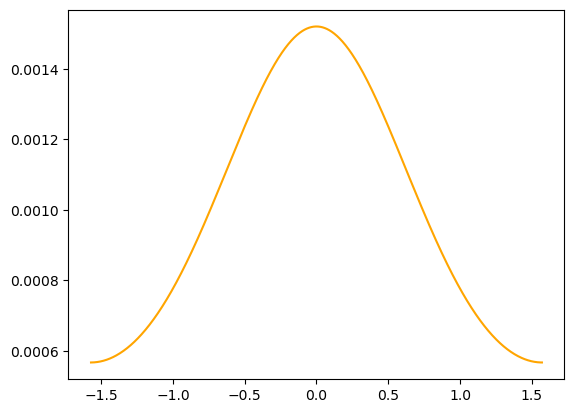

In [10]:
ed_eigvals, ed_eigstates = torch.linalg.eigh(hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, {'V0': V0, 'K1': K1}, x_train))

print(f"Energy of the ground state: {ed_eigvals[0].item()}")
plt.plot(x_train.detach().cpu().numpy(), ed_eigstates[:, 0].detach().cpu().numpy()**2, label='Exact Ground State', color='orange')

In [19]:
# Variational parameters
epochs  = 30_000
Nh      = 30 #100
NLayers = 1
lr      = 0.001
activation_function = "tanh"

energy_history = []
wf_history = []

In [ ]:
layer_dims = [1] + [Nh] * NLayers + [1]

model = MLP(layer_dims=layer_dims, activation=activation_function)
model.to(device)

# init weights
for param in model.parameters():
    if len(param.shape) > 1:  # only initialize weights, not biases
        torch.nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

callback = EarlyStoppingCallback(patience=5000, min_delta=1e-4)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train)     # computes forward pass
    psi = psi / torch.sqrt(torch.trapezoid(torch.conj(psi) * psi, x_train, dim=0))
    T = kinetic_energy(psi,x_train)  # compute kinetic energy
    V_psi = V(x_train,**{'V0': V0, 'K1': K1}) * psi
    H_psi = T + V_psi

    numerator   = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(torch.conj(psi) * psi, x_train, dim=0)
    energy      = numerator / denominator
    energy_copy = energy.clone().detach()
    loss        = energy

    energy_history.append(energy.item())
    wf_history.append(psi.clone())

    penalty = 1e2
    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    #loss    += 1e-1 * (norm_psi - 1)**2  # enforce normalization condition
    psi      = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    loss    += penalty * (psi[0] - psi[-1])**2 # penalize boundary conditions

    dpsi_0   = (psi[1]-psi[-1])/(2*GRID_SPACING)
    dpsi_end = (psi[0]-psi[-2])/(2*GRID_SPACING)
    loss    += penalty*(dpsi_0-dpsi_end)**2 # DERIVATIVE CONDITIONS IN THE PSI!!!!!
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}, Num: {numerator.item():.4f}, Den: {denominator.item():.4f}")

    if callback is not None:
        callback(epoch, loss, model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
# print(energy)
# model.load_state_dict(callback.best_model_state)

Epoch 1/30000, Loss: 70.1713, Energy: 0.6189, Num: 0.6189, Den: 1.0000
Epoch 101/30000, Loss: 0.8876, Energy: 0.5048, Num: 0.5048, Den: 1.0000
Epoch 201/30000, Loss: 0.6994, Energy: 0.5051, Num: 0.5051, Den: 1.0000
Epoch 301/30000, Loss: 0.5801, Energy: 0.5059, Num: 0.5059, Den: 1.0000
Epoch 401/30000, Loss: 0.5265, Energy: 0.5068, Num: 0.5068, Den: 1.0000
Epoch 501/30000, Loss: 0.5111, Energy: 0.5076, Num: 0.5076, Den: 1.0000
Epoch 601/30000, Loss: 0.5085, Energy: 0.5079, Num: 0.5079, Den: 1.0000
Epoch 701/30000, Loss: 0.5082, Energy: 0.5081, Num: 0.5081, Den: 1.0000
Epoch 801/30000, Loss: 0.5081, Energy: 0.5081, Num: 0.5081, Den: 1.0000
Epoch 901/30000, Loss: 0.5081, Energy: 0.5080, Num: 0.5080, Den: 1.0000
Epoch 1001/30000, Loss: 0.5080, Energy: 0.5080, Num: 0.5080, Den: 1.0000
Epoch 1101/30000, Loss: 0.5080, Energy: 0.5080, Num: 0.5080, Den: 1.0000
Epoch 1201/30000, Loss: 0.5079, Energy: 0.5079, Num: 0.5079, Den: 1.0000
Epoch 1301/30000, Loss: 0.5079, Energy: 0.5079, Num: 0.5079, D

### Plotting ED vs Variational

In [21]:
ed_ground_state = ed_eigstates[:, 0].view(-1, 1)

Norm of wavefunction: 0.9999999900000003
shape of ed_eigstates: torch.Size([1000, 1000])
shape of norm_other: torch.Size([1])
type of norm_other: <class 'torch.Tensor'>
Norm of eigenstate: 0.0031429555556498224
New norm of eigenstate: 0.9999968182915712
......................
Energy from ED: 0.439550676111987
Energy from VMC: 0.43873150004394723


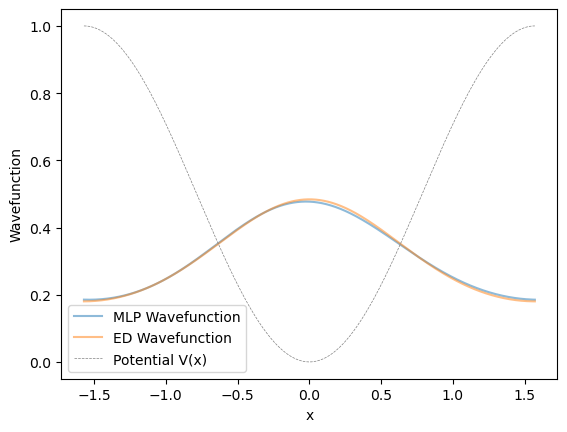

In [22]:
plt.plot(x_train.cpu().detach().numpy(), psi.detach().cpu().numpy()**2, label='MLP Wavefunction', alpha=0.5)
norm = torch.trapezoid(psi.pow(2), x_train, dim=0)
print(f'Norm of wavefunction: {norm.item()}')
print(f"shape of ed_eigstates: {ed_eigstates.shape}")
norm_other = torch.trapezoid(ed_ground_state.pow(2), x_train, dim=0)
print(f"shape of norm_other: {norm_other.shape}")
print(f"type of norm_other: {type(norm_other)}")
print(f'Norm of eigenstate: {norm_other.item()}')
psi_ed = ed_ground_state.clone().detach()/ torch.sqrt(norm_other + 1e-8)  # normalize eigenstate
new_norm = torch.trapezoid(psi_ed.pow(2), x_train, dim=0)
print(f'New norm of eigenstate: {new_norm.item()}')
plt.plot(x_train.detach().cpu().numpy(), psi_ed.cpu().detach().numpy()**2, label='ED Wavefunction', alpha=0.5)
plt.plot(x_train.cpu().detach().numpy(), V(x_train,V0,K1).cpu().detach().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=1, linewidth=0.5)

print("......................")
print(f'Energy from ED: {ed_eigvals[0].item()}')
print(f'Energy from VMC: {energy_copy.item()}')
plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.legend();

In [ ]:
dx  = x_train[2]-x_train[1]
kk  = (psi[2:] - 2*psi[1:-1] + psi[0:-2]) / dx**2
Kin = sum( psi[1:-1] * kk )*dx

VV  = V0 * torch.sin(K1 * x_train).pow(2)
V   = sum(psi * psi * VV)*dx

NN  = sum(psi * psi)*dx

Ktot = -0.5*Kin / NN
Vtot = V / NN
Etot = Ktot + Vtot

Etot , Ktot , Vtot

In [ ]:
np.array(psi.detach()).reshape(1,1000)

In [ ]:
aux = x_train[2]-x_train[1]
aux = aux.detach()
aux.numpy()

In [ ]:
for idx, energy in enumerate(energy_history):
    if energy<0.0:
        # reset gradient in wf_hist
        wf_history[idx] = wf_history[idx].clone()
        plt.plot(x_train.detach().cpu().numpy(), wf_history[idx].detach().cpu().numpy()**2, label=f'VMC Wavefunction Epoch {idx}', alpha=0.5)
        # compute the energy again
        T = numerical_kin_energy(wf_history[idx]).view(-1, 1)
        V_psi = V(x_train,V0,K1) * wf_history[idx]
        H_psi = T + V_psi
        numerator = torch.trapezoid(torch.conj(wf_history[idx]) * H_psi, x_train, dim=0)
        print(T.shape)
        print(V_psi.shape)
        denominator = torch.trapezoid(wf_history[idx].pow(2), x_train, dim=0)
        energy = numerator / denominator
        print(f"Epoch {idx}, Energy: {energy.item():.4f}")

In [ ]:
# compute the energy of the ed with the variational method:
psi_ed = ed_eigstates[:, 0].clone().detach().cpu().to(device).view(-1, 1)  # ensure it is a column vector
T = numerical_kin_energy(psi_ed).view(-1, 1)
V_psi = V(x_train,V0,K1) * psi_ed
H_psi = T + V_psi
numerator = torch.trapezoid(torch.conj(psi_ed) * H_psi, x_train, dim=0)
denominator = torch.trapezoid(psi_ed.pow(2), x_train, dim=0)
energy_ed = numerator / denominator
print(f"Energy of the ED wavefunction: {energy_ed.item():.4f}")